In [2]:
import random
import os
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import scipy.stats as stats
%matplotlib inline
import seaborn as sns
import warnings
import plotly.express as px
import gc
import folium
from tqdm import tqdm
from math import radians, cos, sin, asin, sqrt
from sklearn.model_selection import train_test_split

# csv to parquet 데이터 불러오기

In [3]:
def csv_to_parquet(csv_path, save_name):
    df = pd.read_csv(csv_path)
    df.to_parquet(f'./Dataset/{save_name}.parquet')
    del df
    gc.collect()
    print(save_name, 'Done.')

In [5]:
csv_to_parquet('./Dataset/train.csv', 'train')
csv_to_parquet('./Dataset/test.csv', 'test')

train Done.
test Done.


In [10]:
train = pd.read_parquet('./Dataset/train.parquet')
test = pd.read_parquet('./Dataset/test.parquet')
data_info = pd.read_csv('./Dataset/data_info.csv')

# 자료형 변환

In [11]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int64  
 2   day_of_week            object 
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              object 
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  vehicle_restricted     float64
 11  weight_restricted      float64
 12  height_restricted      float64
 13  road_type              int64  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

In [12]:
# 빠른 탐색을 위한 자료형 변환
to_int32 = ["base_date", "base_hour", "lane_count", "road_rating", "multi_linked", "connect_code", "road_type"]
to_float32 = ["vehicle_restricted", "height_restricted", "maximum_speed_limit", "weight_restricted", "target"]

for i in to_int32:
    train[i] = train[i].astype("int32")
for j in to_float32:
    train[j] = train[j].astype("float32")

In [13]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 4701217 entries, 0 to 4701216
Data columns (total 23 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int32  
 2   day_of_week            object 
 3   base_hour              int32  
 4   lane_count             int32  
 5   road_rating            int32  
 6   road_name              object 
 7   multi_linked           int32  
 8   connect_code           int32  
 9   maximum_speed_limit    float32
 10  vehicle_restricted     float32
 11  weight_restricted      float32
 12  height_restricted      float32
 13  road_type              int32  
 14  start_node_name        object 
 15  start_latitude         float64
 16  start_longitude        float64
 17  start_turn_restricted  object 
 18  end_node_name          object 
 19  end_latitude           float64
 20  end_longitude          float64
 21  end_turn_restricted    object 
 22  target            

- memory 사용량: 825.0+ MB -> 609.7+ MB

In [14]:
train.columns

Index(['id', 'base_date', 'day_of_week', 'base_hour', 'lane_count',
       'road_rating', 'road_name', 'multi_linked', 'connect_code',
       'maximum_speed_limit', 'vehicle_restricted', 'weight_restricted',
       'height_restricted', 'road_type', 'start_node_name', 'start_latitude',
       'start_longitude', 'start_turn_restricted', 'end_node_name',
       'end_latitude', 'end_longitude', 'end_turn_restricted', 'target'],
      dtype='object')

In [15]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,road_type,start_node_name,start_latitude,start_longitude,start_turn_restricted,end_node_name,end_latitude,end_longitude,end_turn_restricted,target
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,3,제3교래교,33.427747,126.662612,없음,제3교래교,33.427749,126.662335,없음,52.0
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0,광양사거리,33.500730,126.529107,있음,KAL사거리,33.504811,126.526240,없음,30.0
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0,창고천교,33.279145,126.368598,없음,상창육교,33.280072,126.362147,없음,61.0
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0,남양리조트,33.246081,126.567204,없음,서현주택,33.245565,126.566228,없음,20.0
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,0,애월샷시,33.462214,126.326551,없음,애월입구,33.462677,126.330152,없음,38.0


# 1. EDA

In [16]:
data_info

,변수명,변수 설명
0,id,아이디
1,base_date,날짜
2,day_of_week,요일
3,base_hour,시간대
4,road_in_use,도로사용여부
5,lane_count,차로수
6,road_rating,도로등급
7,multi_linked,중용구간 여부
8,connect_code,연결로 코드
9,maximum_speed_limit,최고속도제한


In [17]:
len(train)

4701217

In [18]:
train.head().T

,0,1,2,3,4
id,TRAIN_0000000,TRAIN_0000001,TRAIN_0000002,TRAIN_0000003,TRAIN_0000004
base_date,20220623,20220728,20211010,20220311,20211005
day_of_week,목,목,일,금,화
base_hour,17,21,7,13,8
lane_count,1,2,2,2,2
road_rating,106,103,103,107,103
road_name,지방도1112호선,일반국도11호선,일반국도16호선,태평로,일반국도12호선
multi_linked,0,0,0,0,0
connect_code,0,0,0,0,0
maximum_speed_limit,60,60,80,50,80


- 수치형 데이터: 위도, 경도, 평균 속도 (위도, 경도도 범주형 데이터처럼 사용)
- 나머지는 모두 범주형 데이터

## 컬럼에 관한 정보

In [24]:
train['road_rating']

0          106
1          103
2          103
3          107
4          103
          ... 
4701212    107
4701213    107
4701214    103
4701215    103
4701216    107
Name: road_rating, Length: 4701217, dtype: int32

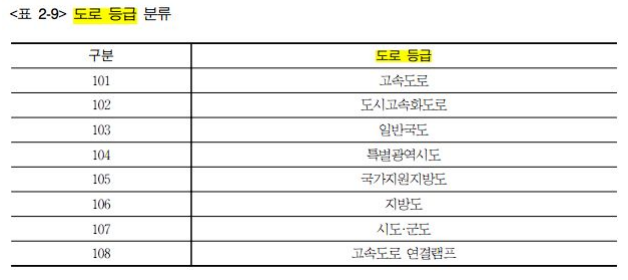

In [26]:
train['connect_code']

0          0
1          0
2          0
3          0
4          0
          ..
4701212    0
4701213    0
4701214    0
4701215    0
4701216    0
Name: connect_code, Length: 4701217, dtype: int32

In [28]:
train['connect_code'].unique()

array([  0, 103])

In [30]:
train['connect_code'].value_counts()

0      4689075
103      12142
Name: connect_code, dtype: int64

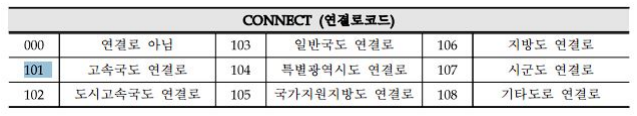

- 값의 불균형 발견

In [21]:
train.groupby(['base_date'])['target'].size()

base_date
20210901    19722
20210902    18809
20210903    19880
20210904    17998
20210905    17836
            ...  
20220727     9195
20220728     7601
20220729     5138
20220730     1845
20220731     5539
Name: target, Length: 281, dtype: int64

- 기간은 2021년 9월 1일부터 2022년 7월 31일까지인 것을 확인

array([[<AxesSubplot:title={'center':'base_date'}>,
        <AxesSubplot:title={'center':'base_hour'}>,
        <AxesSubplot:title={'center':'lane_count'}>,
        <AxesSubplot:title={'center':'road_rating'}>],
       [<AxesSubplot:title={'center':'multi_linked'}>,
        <AxesSubplot:title={'center':'connect_code'}>,
        <AxesSubplot:title={'center':'maximum_speed_limit'}>,
        <AxesSubplot:title={'center':'vehicle_restricted'}>],
       [<AxesSubplot:title={'center':'weight_restricted'}>,
        <AxesSubplot:title={'center':'height_restricted'}>,
        <AxesSubplot:title={'center':'road_type'}>,
        <AxesSubplot:title={'center':'start_latitude'}>],
       [<AxesSubplot:title={'center':'start_longitude'}>,
        <AxesSubplot:title={'center':'end_latitude'}>,
        <AxesSubplot:title={'center':'end_longitude'}>,
        <AxesSubplot:title={'center':'target'}>]], dtype=object)

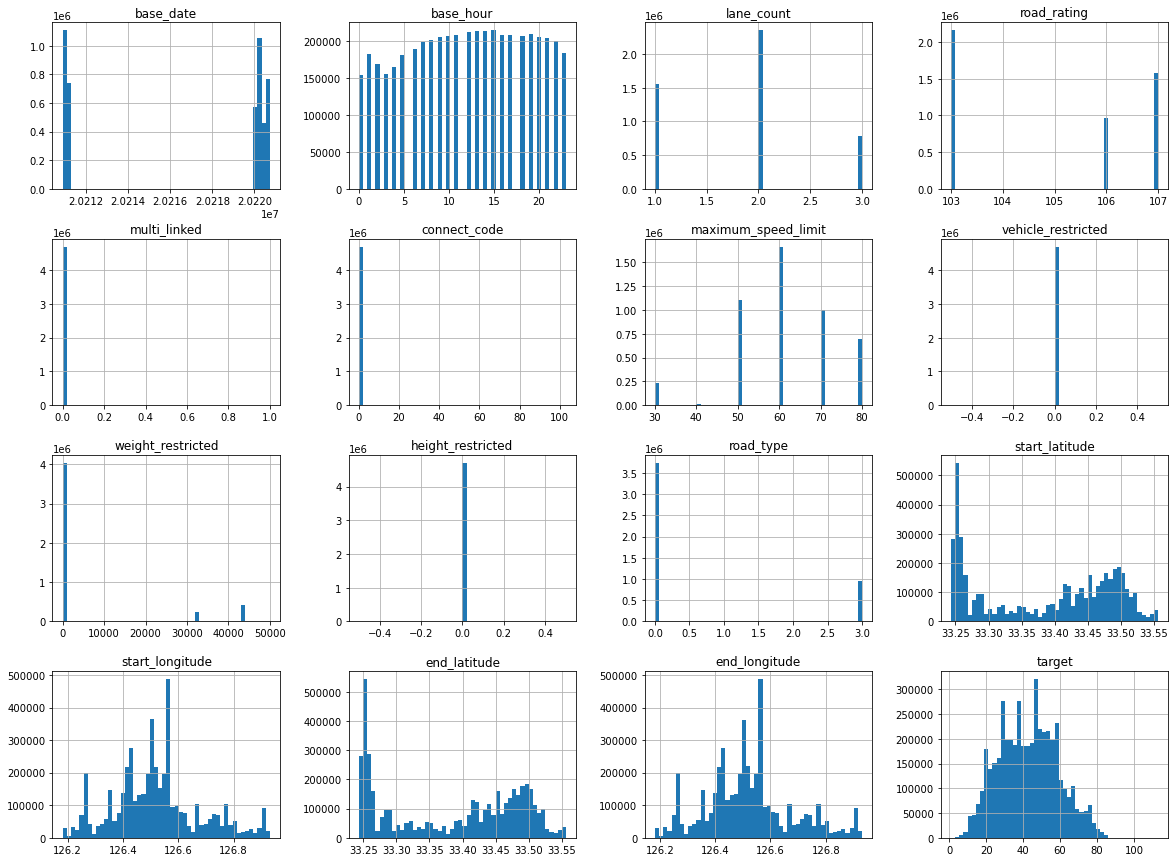

In [31]:
train.hist(bins=50, figsize=(20, 15))

#### 값이 유일한 컬럼 탐색

In [34]:
train_desc = train.describe().transpose()
train_desc[train_desc['std'] == 0].index

Index(['vehicle_restricted', 'height_restricted'], dtype='object')

- 'vehicle_restricted', 'height_restricted' 컬럼은 삭제하기로 함

#### 컬럼별 유니크값 확인

In [38]:
column_names = train.columns.values.tolist()

for i in column_names:
    print(f'{i} = {train[i].nunique()}')

id = 4701217
base_date = 281
day_of_week = 7
base_hour = 24
lane_count = 3
road_rating = 3
road_name = 61
multi_linked = 2
connect_code = 2
maximum_speed_limit = 6
vehicle_restricted = 1
weight_restricted = 4
height_restricted = 1
road_type = 2
start_node_name = 487
start_latitude = 586
start_longitude = 586
start_turn_restricted = 2
end_node_name = 487
end_latitude = 586
end_longitude = 586
end_turn_restricted = 2
target = 102


#### 상관관계 확인

<AxesSubplot:>

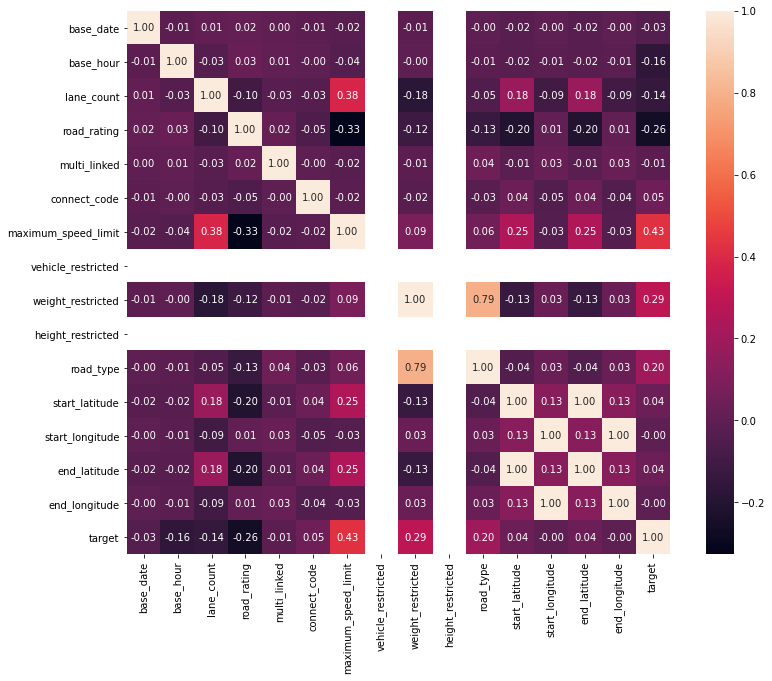

In [36]:
train_corr = train.corr()
f, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(train_corr, annot=True, fmt = '.2f', square=True)

In [71]:
# target 0.2이상 관계
corr = train.corr()
corr[(corr['target']>0.2)]

,base_hour,lane_count,road_rating,multi_linked,connect_code,maximum_speed_limit,vehicle_restricted,weight_restricted,height_restricted,road_type,start_latitude,start_longitude,end_latitude,end_longitude,target,year,month,day
maximum_speed_limit,-0.036756,0.384002,-0.327474,-0.020245,-0.015190,1.000000,NaN,0.085080,NaN,0.059511,0.253147,-0.033018,0.252958,-0.032907,0.425715,-0.017561,0.001396,-0.001759
weight_restricted,-0.003231,-0.177224,-0.118630,-0.008790,-0.020491,0.085080,NaN,1.000000,NaN,0.792803,-0.128291,0.034926,-0.128305,0.034915,0.294092,-0.010346,0.000740,-0.000207
road_type,-0.007880,-0.050715,-0.125618,0.042977,-0.025846,0.059511,NaN,0.792803,NaN,1.000000,-0.043420,0.033684,-0.043430,0.033664,0.200840,-0.004586,0.003837,-0.000432
target,-0.159407,-0.144256,-0.261693,-0.008408,0.048348,0.425715,NaN,0.294092,NaN,0.200840,0.036280,-0.001168,0.036139,-0.001000,1.000000,-0.031676,-0.000225,-0.011605


- 'target'과 뚜렷한 상관관계를 가지고 있는 컬럼의 개수가 적음
- 상관관계가 뚜렷한 데이터부터 꼼꼼히 살펴보며 전처리를 진행해야겠음
- 파생변수 생성과 여러 인코딩 방식을 적극 활용하기로 결정

<AxesSubplot:>

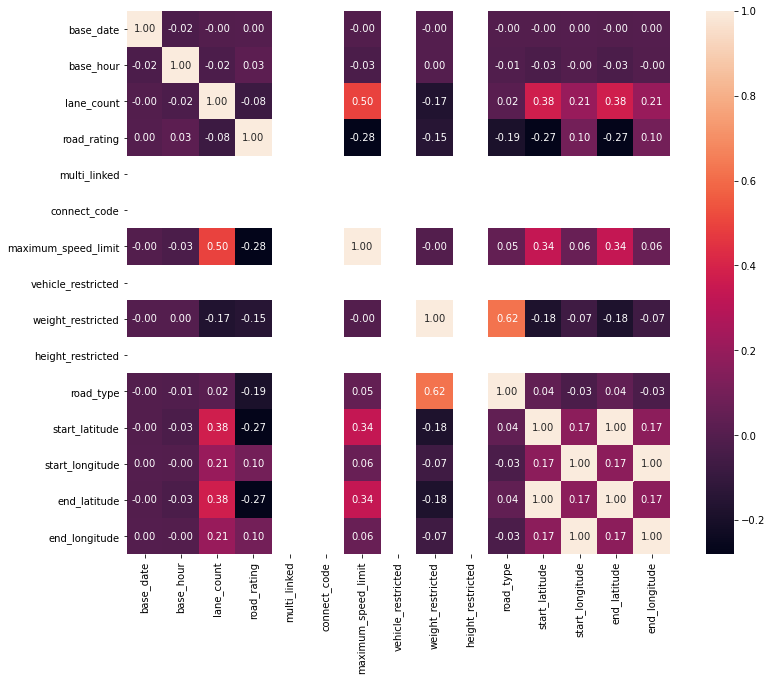

In [39]:
test_corr = test.corr()
f, ax = plt.subplots(figsize=(13, 10))
sns.heatmap(test_corr, annot=True, fmt = '.2f', square=True)

- 'connect_code', 'multi_linked' 컬럼에서 이상한 점 발견

#### 'connect_code'

In [40]:
train.connect_code.value_counts()

0      4689075
103      12142
Name: connect_code, dtype: int64

In [42]:
print(train.groupby('connect_code')['target'].mean())
print(train.groupby('connect_code')['target'].std())      

connect_code
0      42.749191
103    57.947044
Name: target, dtype: float32
connect_code
0      15.949711
103     9.075532
Name: target, dtype: float64


#### 'multi_linked'

In [43]:
train.multi_linked.value_counts()

0    4698978
1       2239
Name: multi_linked, dtype: int64

In [44]:
print(train.groupby('multi_linked')['target'].mean())
print(train.groupby('multi_linked')['target'].std())      

multi_linked
0    42.791370
1    36.642696
Name: target, dtype: float32
multi_linked
0    15.954885
1    13.661950
Name: target, dtype: float64


- 개수의 차이도 심각하고 평균값과 표준편차까지도 차이가 있는 것을 볼 수 있음.
- 컬럼 자체를 제거하기로 결정

In [45]:
train['road_name']

0          지방도1112호선
1           일반국도11호선
2           일반국도16호선
3                태평로
4           일반국도12호선
             ...    
4701212            -
4701213            -
4701214     일반국도12호선
4701215     일반국도95호선
4701216          경찰로
Name: road_name, Length: 4701217, dtype: object

- 'road_name' 컬럼에서도 이상한 점 발견

In [47]:
train['road_name'].unique()

array(['지방도1112호선', '일반국도11호선', '일반국도16호선', '태평로', '일반국도12호선', '경찰로', '-',
       '외도천교', '일반국도99호선', '중정로', '번영로', '연동로', '중산간서로', '지방도1118호선',
       '새서귀로', '지방도1115호선', '지방도1132호선', '어시천교', '지방도1120호선', '삼무로',
       '애조로', '지방도1116호선', '일반국도95호선', '동부관광도로', '동홍로', '지방도97호선', '중문로',
       '연삼로', '중앙로', '산서로', '지방도1117호선', '연북로', '남조로', '지방도1119호선', '동문로',
       '한천로', '삼봉로', '고평교', '연북2교', '관광단지로', '권학로', '시청로', '신대로', '서사로',
       '관덕로', '관광단지1로', '신산로', '관광단지2로', '신광로', '지방도1136호선', '첨단로',
       '제2거로교', '시민광장로', '임항로', '수영장길', '애원로', '삼성로', '일주동로', '호서중앙로',
       '아봉로', '호근로'], dtype=object)

In [55]:
train['road_name'].value_counts()

일반국도12호선    1046092
-            569463
일반국도16호선     554510
일반국도95호선     248181
일반국도11호선     215701
             ...   
애원로            7718
아봉로            7342
남조로            6813
호서중앙로          2819
호근로             587
Name: road_name, Length: 61, dtype: int64

In [56]:
road_name_null = train.groupby([train['road_name'] == '-'])['road_name'].value_counts()
road_name_null

road_name  road_name
False      일반국도12호선     1046092
           일반국도16호선      554510
           일반국도95호선      248181
           일반국도11호선      215701
           지방도1132호선     179200
                         ...   
           아봉로             7342
           남조로             6813
           호서중앙로           2819
           호근로              587
True       -             569463
Name: road_name, Length: 61, dtype: int64

<AxesSubplot:ylabel='road_name'>

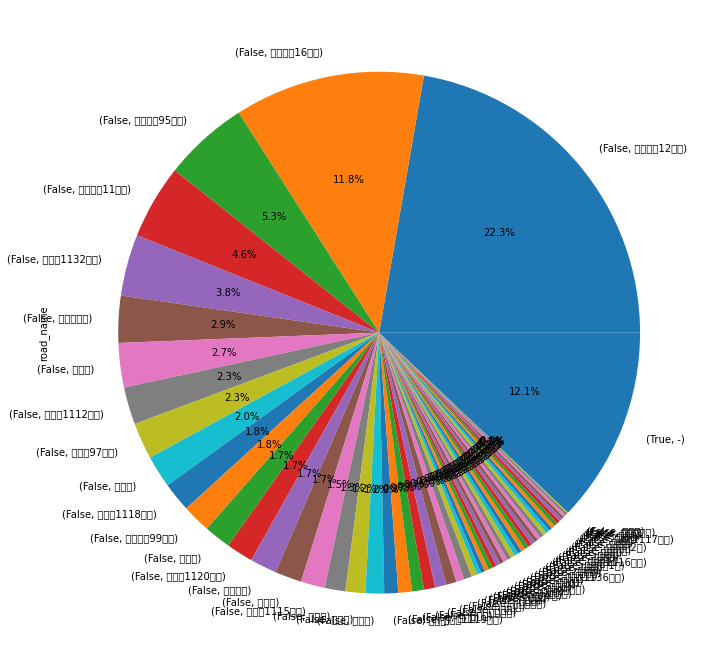

In [66]:
import warnings
warnings.filterwarnings('ignore')

pichart = road_name_null.plot(kind = 'pie', autopct = '%.1f%%', figsize=(16, 12))
pichart

- 도로 이름이 아닌 '-' 값이 무시할 수 없을 정도로 있는 것을 확인(12.1%)

In [68]:
train["base_date"] = pd.to_datetime(train["base_date"],format='%Y%m%d')
train['year']= train['base_date'].dt.year
train['month']= train['base_date'].dt.month
train['day']= train['base_date'].dt.day

#### 일별, 월별 평균속도 그래프

<AxesSubplot:xlabel='month', ylabel='target'>

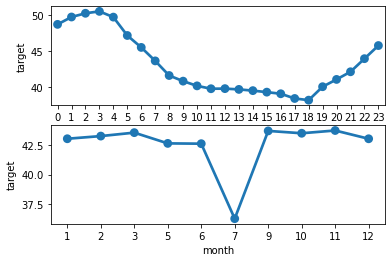

In [69]:
figure, (ax1, ax2) = plt.subplots(nrows=2)
sns.pointplot(data=train, x="base_hour", y="target", ax=ax1)
sns.pointplot(data=train, x="month", y="target", ax=ax2)

- 평균속도의 차이가 확연히 드러나고, 7월에 속도가 낮은 것을 확인할 수 있음

#### 범주형 데이터 확인 

<AxesSubplot:xlabel='end_turn_restricted', ylabel='target'>

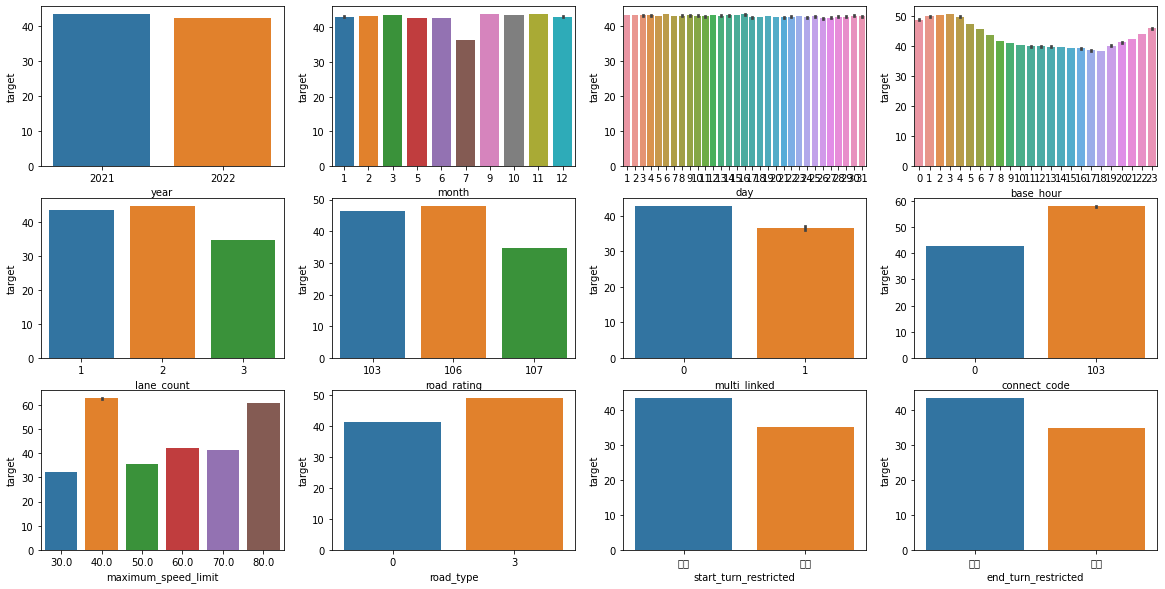

In [70]:
figure, axes = plt.subplots(3,4)
figure.set_size_inches(20, 10)
sns.barplot(data=train, x='year', y='target',ax=axes[0][0])
sns.barplot(data=train, x='month', y='target',ax=axes[0][1])
sns.barplot(data=train, x='day', y='target',ax=axes[0][2])
sns.barplot(data=train, x='base_hour', y='target',ax=axes[0][3])
sns.barplot(data=train, x='lane_count', y='target',ax=axes[1][0])
sns.barplot(data=train, x='road_rating', y='target',ax=axes[1][1])
sns.barplot(data=train, x='multi_linked', y='target',ax=axes[1][2])
sns.barplot(data=train, x='connect_code', y='target',ax=axes[1][3])
sns.barplot(data=train, x='maximum_speed_limit', y='target',ax=axes[2][0])
sns.barplot(data=train, x='road_type', y='target',ax=axes[2][1])
sns.barplot(data=train, x='start_turn_restricted', y='target',ax=axes[2][2])
sns.barplot(data=train, x='end_turn_restricted', y='target',ax=axes[2][3])

In [83]:
train['base_hour'].value_counts()

15    214541
13    214297
14    214182
12    211833
19    209870
11    208515
16    208420
17    208377
18    207500
10    206316
9     205327
20    205059
21    203585
8     201875
22    200629
7     199061
6     189418
23    184229
1     182353
5     181128
2     169322
4     165284
3     155938
0     154158
Name: base_hour, dtype: int64

In [84]:
train['road_rating'].value_counts()

103    2159511
107    1582214
106     959492
Name: road_rating, dtype: int64

In [86]:
train['maximum_speed_limit'].value_counts()

60.0    1665573
50.0    1103682
70.0     995077
80.0     700334
30.0     229761
40.0       6790
Name: maximum_speed_limit, dtype: int64

In [106]:
# 최고 제한속도 확인
train.maximum_speed_limit.value_counts().sort_index()

30.0     229761
40.0       6790
50.0    1103682
60.0    1665573
70.0     995077
80.0     700334
Name: maximum_speed_limit, dtype: int64

In [62]:
# 차로 수 확인
train.lane_count.value_counts()

2    2352092
1    1558531
3     790594
Name: lane_count, dtype: int64

#### 위도, 경도 확인

<AxesSubplot:xlabel='start_longitude', ylabel='start_latitude'>

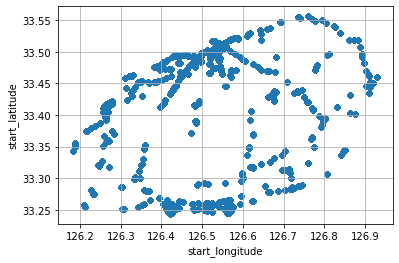

In [35]:
train.plot(kind='scatter', x='start_longitude', y='start_latitude', alpha=0.3, grid=True)

In [ ]:
# map
m = folium.Map(location=[33.427747, 126.662612], zoom_start=10.4, tiles="Stamen Terrain")

tooltip = "Click me!"
a=train[['start_latitude','start_longitude','start_node_name']]
a = a.drop_duplicates()
b=a['start_longitude']
c=a['start_node_name']
a=a['start_latitude']

for i,j,k in zip(a,b,c) :
    folium.Marker([i, j], popup="<i>{}</i>".format(k), tooltip=tooltip).add_to(m)
m

In [7]:
gps = train[['start_longitude', 'end_longitude', 'start_latitude', 'end_latitude', 'target']]

In [9]:
gps_set = [gps['start_longitude'].min(), gps['start_longitude'].max(), gps['start_latitude'].min(), gps['start_latitude'].max()] # 지도 그림의 gps 좌표
gps_set

[126.182616549771, 126.930940973848, 33.2434317486804, 33.5560801767072]

In [ ]:
from tqdm import tqdm

In [49]:
vel_low_idx = gps.loc[gps['target']<15].index # 시내 교통 체증기준 10 km/h 미만
vel_high_idx = gps.loc[gps['target']>80].index # 고속도로 원활기준 80 km/h 초과

100%|██████████| 26239/26239 [00:16<00:00, 1558.22it/s]


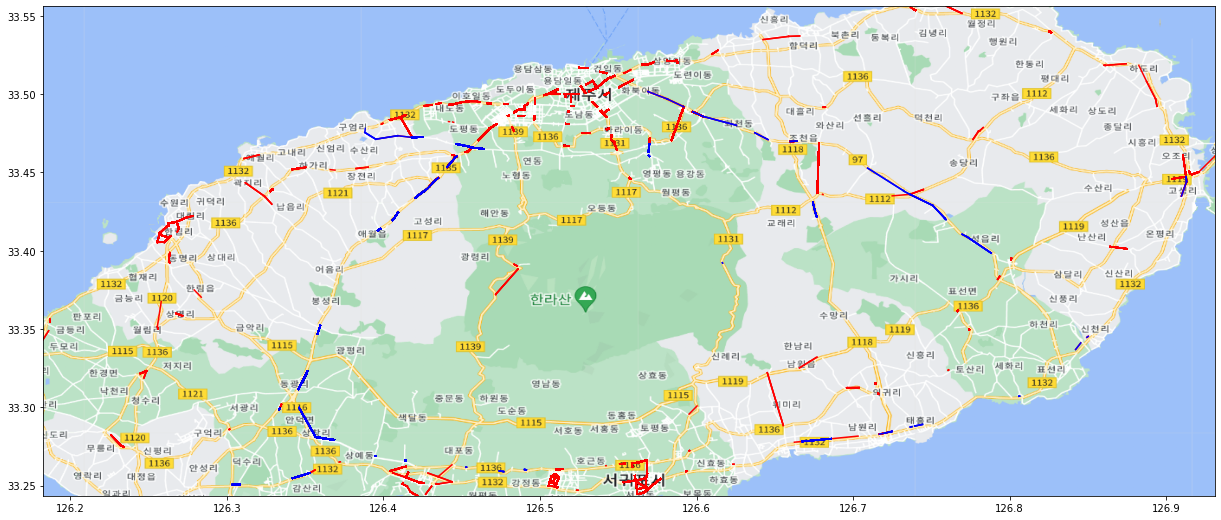

In [84]:

f, ax = plt.subplots(figsize=(21,10))

ax.set_xlim(gps_set[0], gps_set[1])
ax.set_ylim(gps_set[2], gps_set[3])

image = plt.imread('map5.png')
ax.imshow(image, zorder=0, extent=gps_set, aspect='equal')

for i in tqdm(vel_low_idx): # 교통 체증 도로 빨강
    x_1 = gps.loc[i,'start_longitude']
    x_2 = gps.loc[i,'end_longitude'] 
    y_1 = gps.loc[i,'start_latitude']
    y_2 = gps.loc[i,'end_latitude'] 
    ax.plot([x_1, x_2], [y_1, y_2], color='red')

for i in tqdm(vel_high_idx): # 교통 원활 도로 파랑
    x_1 = gps.loc[i,'start_longitude']
    x_2 = gps.loc[i,'end_longitude'] 
    y_1 = gps.loc[i,'start_latitude']
    y_2 = gps.loc[i,'end_latitude'] 
    ax.plot([x_1, x_2], [y_1, y_2], color='blue')

plt.show()

C:\Users\Playdata\anaconda3\lib\site-packages\seaborn\distributions.py:2619: FutureWarning: `distplot` is a deprecated function and will be removed in a future version. Please adapt your code to use either `displot` (a figure-level function with similar flexibility) or `histplot` (an axes-level function for histograms).
  warnings.warn(msg, FutureWarning)


<AxesSubplot:xlabel='maximum_speed_limit', ylabel='Density'>

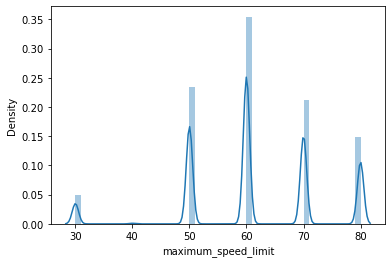

In [58]:
sns.distplot(train.maximum_speed_limit)

<AxesSubplot:xlabel='maximum_speed_limit', ylabel='target'>

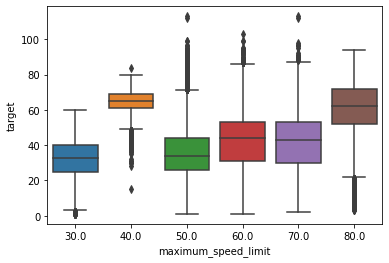

In [59]:
sns.boxplot(x = "maximum_speed_limit", y = "target", data = train)

#### maximum_spped_limit 극단치확인 전처리과정에서 제거

<AxesSubplot:xlabel='target', ylabel='Count'>

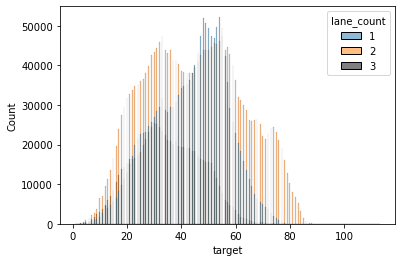

In [63]:
sns.histplot(x = train.target, hue = train.lane_count, palette=["C0", "C1", "k"])

##### 차로 수 확인

In [71]:
for i in train.groupby("lane_count")["target"].mean() :
    print(i)

43.57056163785
44.9157129057877
34.917783337591736


<AxesSubplot:xlabel='lane_count', ylabel='target'>

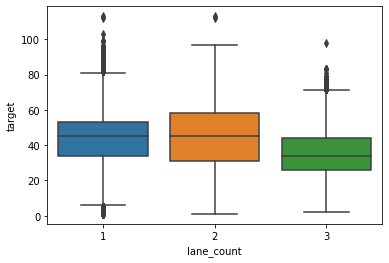

In [82]:
sns.boxplot(x = train.lane_count, y = train.target)

##### 예상과는 반대로 차선이 수가 늘어날 수록 오히려 정체되는 모습을 보임. 모델학습 시 활용

# 2. Data Preprocessing

```
컬럼 삭제
'distance', 'airport_distance' 컬럼 생성
'center_start', 'center_end' 컬럼 생성
Target Encoding
결측값 제거
'season' 컬럼 추가
'work_or_rest_or_other' 컬럼 추가
'target' 이상치 제거
Label Encoding
```

## 컬럼 삭제

### 값이 유일한 컬럼 탐색

In [12]:
train_desc = train.describe().transpose()
train_desc[train_desc['std']==0].index

Index(['vehicle_restricted', 'height_restricted'], dtype='object')

### 'vehicle_restricted', 'height_restricted' 삭제

In [14]:
train = train.drop(columns=['vehicle_restricted', 'height_restricted'])
test = test.drop(columns=['vehicle_restricted', 'height_restricted'])
train.shape, test.shape

((4701217, 21), (291241, 20))

## 지리 데이터 (공간 파생변수)

### 두 지점 사이의 거리

In [16]:
# https://www.kaggle.com/code/speedoheck/calculate-distance-with-geo-coordinates/notebook

from math import radians, cos, sin, asin, sqrt

def haversine(row):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1 = row['start_longitude']
    lat1 = row['start_latitude']
    lon2 = row['end_longitude']
    lat2 = row['end_latitude']

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

train['distance'] = train.apply(haversine, axis=1)
test['distance'] = test.apply(haversine, axis=1)

### 제주공항까지 거리

In [19]:
def haversine_airport(row):
    """
    Calculate the great circle distance between two points 
    on the earth (specified in decimal degrees)
    """
    # convert decimal degrees to radians
    lon1 = 126.4913534
    lat1 = 33.5104135
    lon2 = (row['start_longitude'] + row['end_longitude']) / 2
    lat2 = (row['start_latitude'] + row['end_latitude']) / 2

    lon1, lat1, lon2, lat2 = map(radians, [lon1, lat1, lon2, lat2])
    # haversine formula 
    dlon = lon2 - lon1 
    dlat = lat2 - lat1 
    a = sin(dlat/2)**2 + cos(lat1) * cos(lat2) * sin(dlon/2)**2
    c = 2 * asin(sqrt(a)) 
    km = 6367 * c
    return km

train['airport_distance'] = train.apply(haversine_airport, axis=1)
test['airport_distance'] = test.apply(haversine_airport, axis=1)

### 제주도 권역별 구분하여 변수 추가
- 제주시 도심 : 126.4531517 ~ 126.5900257 , 33.4670429 ~
- 서귀포 도심 : 126.3972753 ~ 126.6076604 , ~ 33.2686052

In [20]:
# 출발지점 권역
mask_jj_start = (train['start_longitude'] > 126.4531517) & (train['start_longitude']< 126.5900257) & (train['start_latitude'] > 33.4670429)
mask_jj_end = (train['end_longitude'] > 126.4531517) & (train['end_longitude']< 126.5900257) & (train['end_latitude'] > 33.4670429)

mask_sgp_start = (train['start_longitude'] > 126.3972753) & (train['start_longitude']< 126.6076604) & (train['start_latitude'] < 33.2686052)
mask_sgp_end = (train['end_longitude'] > 126.3972753) & (train['end_longitude']< 126.6076604) & (train['end_latitude'] < 33.2686052)

In [21]:
train['center_start'] = 0
test['center_start'] = 0

train.loc[mask_jj_start, 'center_start'] = 1
train.loc[mask_sgp_start, 'center_start'] = 2

test.loc[mask_jj_start, 'center_start'] = 1
test.loc[mask_sgp_start, 'center_start'] = 2

train['center_end'] = 0
test['center_end'] = 0

train.loc[mask_jj_end, 'center_end'] = 1
train.loc[mask_sgp_end, 'center_end'] = 2

test.loc[mask_jj_end, 'center_end'] = 1
test.loc[mask_sgp_end, 'center_end'] = 2

### GPS 정보를 사용해서 road 구분

In [22]:
train['road_code'] = train['start_latitude'].astype(str)+'_'+train['start_longitude'].astype(str)+'_'+train['end_latitude'].astype(str)+'_'+train['end_longitude'].astype(str)
train['road_code'].value_counts()

33.3058672207151_126.599081327413_33.3082357708673_126.598689775097    6477
33.3082357708673_126.598689775097_33.3058672207151_126.599081327413    6397
33.5014774884938_126.569223187609_33.4968633703578_126.58123009621     6077
33.5016270326083_126.568923085567_33.5014774884938_126.569223187609    6077
33.496710616894_126.581529061335_33.4918481088766_126.591872255149     6075
                                                                       ... 
33.2566709359707_126.52441046863_33.2541529264473_126.524330998601      744
33.26127013848_126.524428741607_33.2574097173209_126.524412034435       744
33.2574097173209_126.524412034435_33.2566709359707_126.52441046863      744
33.2574097173209_126.524412034435_33.26127013848_126.524428741607       587
33.2574006381515_126.52574476307_33.2574097173209_126.524412034435      587
Name: road_code, Length: 904, dtype: int64

In [23]:
test['road_code'] = test['start_latitude'].astype(str)+'_'+test['start_longitude'].astype(str)+'_'+test['end_latitude'].astype(str)+'_'+test['end_longitude'].astype(str)
test['road_code'].value_counts()

33.508463678702_126.558231105407_33.5087115227295_126.558702856002     740
33.4937925855376_126.492189386746_33.4923347723675_126.490247073997    740
33.4666066165642_126.454021511351_33.4664333666973_126.454583167413    740
33.4923347723675_126.490247073997_33.4937925855376_126.492189386746    740
33.4658632729266_126.456384480352_33.4664333666973_126.454583167413    740
                                                                      ... 
33.3452396554215_126.850113181832_33.3446283972409_126.849278713014      7
33.4857069297096_126.604162168012_33.4886994919865_126.597620980703      7
33.4379464931581_126.73250865826_33.4383285187565_126.732031757687       7
33.4359411786532_126.736248543312_33.4379464931581_126.73250865826       7
33.4288406442461_126.750881044473_33.4359411786532_126.736248543312      7
Name: road_code, Length: 441, dtype: int64

### Target Encoding

In [24]:
road_stats = train.groupby(['road_code'])[['target']].agg(['min', 'mean', 'max', 'std']).reset_index()
road_stats.columns = ['road_code', 'road_min', 'road_mean', 'road_max', 'road_std']
train = train.merge(road_stats, how='left', on='road_code')
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,lon_change,distance,airport_distance,center_start,center_end,road_code,road_min,road_mean,road_max,road_std
0,TRAIN_0000000,20220623,목,17,1,106,지방도1112호선,0,0,60.0,...,0.000277,0.025694,18.330548,0,0,33.427747274683_126.662612038652_33.4277487730...,16.0,51.756910,72.0,4.587047
1,TRAIN_0000001,20220728,목,21,2,103,일반국도11호선,0,0,60.0,...,0.002867,0.525560,3.470872,1,1,33.5007304293026_126.529106761554_33.504811303...,5.0,26.400712,59.0,7.102290
2,TRAIN_0000002,20211010,일,7,2,103,일반국도16호선,0,0,80.0,...,0.006450,0.608016,28.185912,0,0,33.2791450972975_126.368597660936_33.280072104...,32.0,59.101720,88.0,12.091252
3,TRAIN_0000003,20220311,금,13,2,107,태평로,0,0,50.0,...,0.000976,0.107285,30.222870,2,2,33.2460808686345_126.56720431031_33.2455654004...,2.0,25.024923,51.0,7.667545
4,TRAIN_0000004,20211005,화,8,2,103,일반국도12호선,0,0,80.0,...,-0.003601,0.337736,16.019878,0,0,33.4622143482158_126.326551111199_33.462676772...,25.0,39.873670,72.0,6.946840


In [25]:
test = test.merge(road_stats, how='left', on='road_code')
print(test['road_code'].isnull().sum())
test.head()

0


,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,lon_change,distance,airport_distance,center_start,center_end,road_code,road_min,road_mean,road_max,road_std
0,TEST_000000,20220825,목,17,3,107,연삼로,0,0,70.0,...,-0.002538,0.278752,4.881938,0,0,33.4994265233055_126.541298167922_33.500772491...,9.0,33.623164,60.0,9.997806
1,TEST_000001,20220809,화,12,2,103,일반국도12호선,0,0,70.0,...,0.011164,1.038287,28.756351,1,1,33.2585071159642_126.427003448638_33.258119397...,21.0,48.359276,69.0,5.381406
2,TEST_000002,20220805,금,2,1,103,일반국도16호선,0,0,60.0,...,0.001820,0.171335,27.967410,0,0,33.2589595714352_126.476507600171_33.259205665...,35.0,59.993453,86.0,5.444524
3,TEST_000003,20220818,목,23,3,103,일반국도11호선,0,0,70.0,...,0.000180,0.270917,6.572143,2,2,33.4734941166381_126.54564685499_33.4710608036...,6.0,33.185444,55.0,6.060564
4,TEST_000004,20220810,수,17,3,106,번영로,0,0,70.0,...,-0.012007,1.225101,7.871524,0,0,33.5014774884938_126.569223187609_33.496863370...,10.0,46.299654,83.0,6.779434


### 'road_name' 컬럼의  "-" (결측값) 제거

In [26]:
drop_road_name_index = train[train["road_name"] == "-"].index
temp_train = train.iloc[drop_road_name_index]
temp_train

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,lon_change,distance,airport_distance,center_start,center_end,road_code,road_min,road_mean,road_max,road_std
6,TRAIN_0000006,20220106,목,0,2,107,-,0,0,60.0,...,-0.001349,0.487165,23.139421,0,0,33.418411972574_126.268029025365_33.4141750121...,2.0,37.754143,72.0,6.166624
14,TRAIN_0000014,20220203,목,16,1,107,-,0,0,60.0,...,0.000767,0.073214,24.778337,0,0,33.3169132415404_126.624634355945_33.317065379...,30.0,58.279321,72.0,4.900624
28,TRAIN_0000028,20220612,일,14,2,107,-,0,0,50.0,...,-0.000808,0.076826,23.654612,0,0,33.3308220849345_126.354178885417_33.330672710...,23.0,58.649140,72.0,4.145843
30,TRAIN_0000030,20220623,목,6,2,107,-,0,0,80.0,...,0.009314,0.872175,8.313546,0,0,33.4722764927296_126.418442753822_33.473390153...,10.0,60.106969,87.0,5.821785
31,TRAIN_0000031,20211028,목,15,1,107,-,0,0,60.0,...,-0.000308,0.033301,27.020508,0,0,33.3372436401165_126.695809499868_33.337397876...,17.0,46.824555,69.0,5.048228
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
4701204,TRAIN_4701204,20211001,금,19,1,107,-,0,0,60.0,...,-0.010732,1.240364,26.207930,0,0,33.3250958586337_126.665698173918_33.331742200...,11.0,57.356468,71.0,3.816154
4701205,TRAIN_4701205,20220112,수,19,1,107,-,0,0,50.0,...,0.004414,0.442984,40.172235,0,0,33.450215274642_126.920771364786_33.4486894847...,7.0,33.133922,72.0,12.865501
4701208,TRAIN_4701208,20220323,수,19,2,107,-,0,0,80.0,...,-0.000987,0.095026,33.663477,0,0,33.2873555929438_126.736525350221_33.287581677...,32.0,58.925765,93.0,4.357269
4701212,TRAIN_4701212,20211104,목,16,1,107,-,0,0,50.0,...,0.004374,0.426736,22.277728,0,0,33.4221445845451_126.278124511889_33.420954611...,9.0,27.620482,53.0,5.777613


In [27]:
print(temp_train["road_rating"].value_counts())
print(temp_train["weight_restricted"].value_counts())
print("----------------------------------")
print(train[(train["road_rating"] == 107) & (train["weight_restricted"] == 43200.0)]["road_name"].value_counts())
print(train[(train["road_rating"] == 107) & (train["weight_restricted"] == 32400.0)]["road_name"].value_counts())

107    569463
Name: road_rating, dtype: int64
0.0        481943
43200.0     68013
32400.0     19507
Name: weight_restricted, dtype: int64
----------------------------------
-      68013
중문로    11336
Name: road_name, dtype: int64
-      19507
산서로     7940
Name: road_name, dtype: int64


- 'road_name'이 "-"인 값은 모두 road_rating이 107입니다.
- 'road_name'이 "-" 인 값에서 'weight_restricted'가 43200인 곳은 "중문로", 32400인 곳은 "산서로"입니다.
- 이들을 모두 대체하겠습니다.

In [28]:
# .loc로 값 대체하기 전의 수 = 569463
print(len(train[train["road_name"] == "-"]))
train.loc[(train["road_rating"] == 107) & (train["weight_restricted"] == 32400.0) & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["road_rating"] == 107) & (train["weight_restricted"] == 43200.0) & (train["road_name"] == "-"), "road_name"] = "중문로"

test.loc[(test["road_rating"] == 107) & (test["weight_restricted"] == 32400.0) & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["road_rating"] == 107) & (test["weight_restricted"] == 43200.0) & (test["road_name"] == "-"), "road_name"] = "중문로"

# .loc로 값 대체한 이후의 수 = 481943
print(len(train[train["road_name"] == "-"]))

569463
481943


- 약 8만7천개의 "-" 값을 대체
- 추가적으로 "-" 값을 탐색

In [29]:
# "-" 값 대체를 위한 탐색"
# 모든 값을 뽑으면 너무 길어지기에, 2개 값만을 출력합니다.
for i in train["start_node_name"].unique():
    if (len(train[(train["start_node_name"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in train[(train["start_node_name"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(train[(train["start_node_name"] == i)]["road_name"].value_counts())

---------------- 송목교 -------------------
중문로    10390
-       5183
Name: road_name, dtype: int64
---------------- 남수교 -------------------
중문로    10360
-       5156
Name: road_name, dtype: int64
---------------- 하귀입구 -------------------
일반국도12호선    10656
-            5190
Name: road_name, dtype: int64
---------------- 양계장 -------------------
-           5330
일반국도12호선    5329
Name: road_name, dtype: int64
---------------- 난산입구 -------------------
지방도1119호선    4923
-            3113
Name: road_name, dtype: int64
---------------- 영주교 -------------------
일반국도11호선    23909
-             472
Name: road_name, dtype: int64
---------------- 서중2교 -------------------
중문로    10380
-       5204
Name: road_name, dtype: int64
---------------- 천제이교 -------------------
-      10930
산서로    10706
Name: road_name, dtype: int64
---------------- 하나로교 -------------------
중문로    10578
-       5282
Name: road_name, dtype: int64
---------------- 신하교 -------------------
중문로    10390
-       5205
Name: road_name, 

- 위에서 나온 값들을 다음과 같이 대체

In [30]:
print(len(train[train["road_name"] == "-"]))

train.loc[(train["start_node_name"] == "송목교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_node_name"] == "남수교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_node_name"] == "하귀입구") & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["start_node_name"] == "양계장") & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["start_node_name"] == "난산입구") & (train["road_name"] == "-"), "road_name"] = "지방도1119호선"
train.loc[(train["start_node_name"] == "영주교") & (train["road_name"] == "-"), "road_name"] = "일반국도11호선"
train.loc[(train["start_node_name"] == "서중2교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_node_name"] == "천제이교") & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["start_node_name"] == "하나로교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_node_name"] == "신하교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_node_name"] == "야영장") & (train["road_name"] == "-"), "road_name"] = "관광단지1로"
train.loc[(train["start_node_name"] == "월계교") & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["start_node_name"] == "서울이용원") & (train["road_name"] == "-"), "road_name"] = "태평로"
train.loc[(train["start_node_name"] == "김녕교차로") & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["start_node_name"] == "어도초등교") & (train["road_name"] == "-"), "road_name"] = "일반국도16호선"
train.loc[(train["start_node_name"] == "광삼교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_node_name"] == "오렌지농원") & (train["road_name"] == "-"), "road_name"] = "일반국도11호선"
train.loc[(train["start_node_name"] == "우사") & (train["road_name"] == "-"), "road_name"] = "일반국도16호선"
train.loc[(train["start_node_name"] == "서귀포시산림조합") & (train["road_name"] == "-"), "road_name"] = "지방도1136호선"
train.loc[(train["start_node_name"] == "성읍삼거리") & (train["road_name"] == "-"), "road_name"] = "일반국도16호선"

test.loc[(test["start_node_name"] == "송목교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_node_name"] == "남수교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_node_name"] == "하귀입구") & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["start_node_name"] == "양계장") & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["start_node_name"] == "난산입구") & (test["road_name"] == "-"), "road_name"] = "지방도1119호선"
test.loc[(test["start_node_name"] == "영주교") & (test["road_name"] == "-"), "road_name"] = "일반국도11호선"
test.loc[(test["start_node_name"] == "서중2교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_node_name"] == "천제이교") & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["start_node_name"] == "하나로교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_node_name"] == "신하교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_node_name"] == "야영장") & (test["road_name"] == "-"), "road_name"] = "관광단지1로"
test.loc[(test["start_node_name"] == "월계교") & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["start_node_name"] == "서울이용원") & (test["road_name"] == "-"), "road_name"] = "태평로"
test.loc[(test["start_node_name"] == "김녕교차로") & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["start_node_name"] == "어도초등교") & (test["road_name"] == "-"), "road_name"] = "일반국도16호선"
test.loc[(test["start_node_name"] == "광삼교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_node_name"] == "오렌지농원") & (test["road_name"] == "-"), "road_name"] = "일반국도11호선"
test.loc[(test["start_node_name"] == "우사") & (test["road_name"] == "-"), "road_name"] = "일반국도16호선"
test.loc[(test["start_node_name"] == "서귀포시산림조합") & (test["road_name"] == "-"), "road_name"] = "지방도1136호선"
test.loc[(test["start_node_name"] == "성읍삼거리") & (test["road_name"] == "-"), "road_name"] = "일반국도16호선"

print(len(train[train["road_name"] == "-"]))

481943
379668


- 약 10만개의 값이 대체
- 이어서 대체할 값을 탐색

In [31]:
# "-" 값 대체를 위한 탐색"
for i in train["end_node_name"].unique():
    if (len(train[(train["end_node_name"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in train[(train["end_node_name"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(train[(train["end_node_name"] == i)]["road_name"].value_counts())

---------------- 남수교 -------------------
중문로    10360
-       5187
Name: road_name, dtype: int64
---------------- 농협주유소 -------------------
-      8053
산서로    5089
Name: road_name, dtype: int64
---------------- 난산입구 -------------------
지방도1119호선    4978
-            2946
Name: road_name, dtype: int64
---------------- 성읍삼거리 -------------------
일반국도16호선    5030
-           4670
Name: road_name, dtype: int64
---------------- 김녕교차로 -------------------
일반국도12호선    5281
-           3266
Name: road_name, dtype: int64
---------------- 한남교차로 -------------------
중문로    5204
-      5198
Name: road_name, dtype: int64
---------------- 서울이용원 -------------------
태평로    11653
-       1417
Name: road_name, dtype: int64
---------------- 하귀입구 -------------------
일반국도12호선    10661
-            5144
Name: road_name, dtype: int64
---------------- 우사 -------------------
일반국도16호선    7677
-           4784
Name: road_name, dtype: int64
---------------- 어도초등교 -------------------
-           7053
일반국도16호선    5135

In [32]:
print(len(train[train["road_name"] == "-"]))

train.loc[(train["end_node_name"] == "남수교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["end_node_name"] == "농협주유소") & (train["road_name"] == "-"), "road_name"] = "월계교"
train.loc[(train["end_node_name"] == "난산입구") & (train["road_name"] == "-"), "road_name"] = "지방도1119호선"
train.loc[(train["end_node_name"] == "성읍삼거리") & (train["road_name"] == "-"), "road_name"] = "일반국도16호선"
train.loc[(train["end_node_name"] == "김녕교차로") & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["end_node_name"] == "한남교차로") & (train["road_name"] == "-"), "road_name"] = "서중2교"
train.loc[(train["end_node_name"] == "서울이용원") & (train["road_name"] == "-"), "road_name"] = "태평로"
train.loc[(train["end_node_name"] == "하귀입구") & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["end_node_name"] == "어도초등교") & (train["road_name"] == "-"), "road_name"] = "일반국도16호선"
train.loc[(train["end_node_name"] == "월계교") & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["end_node_name"] == "양계장") & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["end_node_name"] == "하나로교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["end_node_name"] == "광삼교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["end_node_name"] == "수간교차로") & (train["road_name"] == "-"), "road_name"] = "양계장"
train.loc[(train["end_node_name"] == "난산사거리") & (train["road_name"] == "-"), "road_name"] = "난산입구"
train.loc[(train["end_node_name"] == "서중2교") & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["end_node_name"] == "서귀포시산림조합") & (train["road_name"] == "-"), "road_name"] = "지방도1136호선"
train.loc[(train["end_node_name"] == "옹포사거리") & (train["road_name"] == "-"), "road_name"] = "월계교"
train.loc[(train["end_node_name"] == "진은교차로") & (train["road_name"] == "-"), "road_name"] = "하나로교"

test.loc[(test["end_node_name"] == "남수교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["end_node_name"] == "농협주유소") & (test["road_name"] == "-"), "road_name"] = "월계교"
test.loc[(test["end_node_name"] == "난산입구") & (test["road_name"] == "-"), "road_name"] = "지방도1119호선"
test.loc[(test["end_node_name"] == "성읍삼거리") & (test["road_name"] == "-"), "road_name"] = "일반국도16호선"
test.loc[(test["end_node_name"] == "김녕교차로") & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["end_node_name"] == "한남교차로") & (test["road_name"] == "-"), "road_name"] = "서중2교"
test.loc[(test["end_node_name"] == "서울이용원") & (test["road_name"] == "-"), "road_name"] = "태평로"
test.loc[(test["end_node_name"] == "하귀입구") & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["end_node_name"] == "어도초등교") & (test["road_name"] == "-"), "road_name"] = "일반국도16호선"
test.loc[(test["end_node_name"] == "월계교") & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["end_node_name"] == "양계장") & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["end_node_name"] == "하나로교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["end_node_name"] == "광삼교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["end_node_name"] == "수간교차로") & (test["road_name"] == "-"), "road_name"] = "양계장"
test.loc[(test["end_node_name"] == "난산사거리") & (test["road_name"] == "-"), "road_name"] = "난산입구"
test.loc[(test["end_node_name"] == "서중2교") & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["end_node_name"] == "서귀포시산림조합") & (test["road_name"] == "-"), "road_name"] = "지방도1136호선"
test.loc[(test["end_node_name"] == "옹포사거리") & (test["road_name"] == "-"), "road_name"] = "월계교"
test.loc[(test["end_node_name"] == "진은교차로") & (test["road_name"] == "-"), "road_name"] = "하나로교"

print(len(train[train["road_name"] == "-"]))

379668
282684


- 이번에는 약 9만 6천개의 데이터가 대체

In [33]:
# 소숫점 문제상 출력된 값을 그대로 사용한다면 값을 대체할 수 없는 문제가 있습니다.
# 이를 해결하기 위해서 소숫점의 자릿수를 제한하겠습니다.
print(train["start_latitude"].nunique(),train["start_longitude"].nunique(), train["end_latitude"].nunique(), train["end_longitude"].nunique())

# 7번째자리에서 반올림 할 경우 train에서의 고윳값 갯수가 변하지 않습니다
train[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]] = train[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]].apply(lambda x: round(x, 6))
test[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]] = test[["start_latitude", "start_longitude", "end_latitude", "end_longitude"]].apply(lambda x: round(x, 6))

print(train["start_latitude"].nunique(),train["start_longitude"].nunique(), train["end_latitude"].nunique(), train["end_longitude"].nunique())

586 586 586 586
586 586 586 586


- 고윳값의 갯수가 변하지 않은 것을 확인할 수 있습니다.
- 이어서 위도, 경도를 바탕으로 대체할 수 있는 값을 찾아보겠습니다

In [34]:
for i in train["start_latitude"].unique():
    if (len(train[(train["start_latitude"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in train[(train["start_latitude"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(train[(train["start_latitude"] == i)]["road_name"].value_counts())

---------------- 33.409416 -------------------
-      3321
월계교    3184
Name: road_name, dtype: int64
---------------- 33.402546 -------------------
-            2953
지방도1119호선    2946
Name: road_name, dtype: int64
---------------- 33.471164 -------------------
-           5334
일반국도12호선    5331
Name: road_name, dtype: int64
---------------- 33.411255 -------------------
-      7382
월계교    4338
Name: road_name, dtype: int64
---------------- 33.405319 -------------------
산서로    4821
-      4159
Name: road_name, dtype: int64
---------------- 33.322018 -------------------
서중2교    5198
-       2396
Name: road_name, dtype: int64
---------------- 33.325096 -------------------
중문로    5187
-      5187
Name: road_name, dtype: int64
---------------- 33.408431 -------------------
-      8441
산서로    4777
Name: road_name, dtype: int64
---------------- 33.284189 -------------------
중문로    5306
-      5288
Name: road_name, dtype: int64
---------------- 33.47339 -------------------
-      5344
양계장    53

In [35]:
print(len(train[train["road_name"] == "-"]))

train.loc[(train["start_latitude"] == 33.409416) & (train["road_name"] == "-"), "road_name"] = "월계교"
train.loc[(train["start_latitude"] == 33.402546) & (train["road_name"] == "-"), "road_name"] = "지방도1119호선"
train.loc[(train["start_latitude"] == 33.471164) & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["start_latitude"] == 33.411255) & (train["road_name"] == "-"), "road_name"] = "월계교"
train.loc[(train["start_latitude"] == 33.405319) & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["start_latitude"] == 33.322018) & (train["road_name"] == "-"), "road_name"] = "서중2교"
train.loc[(train["start_latitude"] == 33.325096) & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_latitude"] == 33.408431) & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["start_latitude"] == 33.284189) & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_latitude"] == 33.47339) & (train["road_name"] == "-"), "road_name"] = "양계장"

test.loc[(test["start_latitude"] == 33.409416) & (test["road_name"] == "-"), "road_name"] = "월계교"
test.loc[(test["start_latitude"] == 33.402546) & (test["road_name"] == "-"), "road_name"] = "지방도1119호선"
test.loc[(test["start_latitude"] == 33.471164) & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["start_latitude"] == 33.411255) & (test["road_name"] == "-"), "road_name"] = "월계교"
test.loc[(test["start_latitude"] == 33.405319) & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["start_latitude"] == 33.322018) & (test["road_name"] == "-"), "road_name"] = "서중2교"
test.loc[(test["start_latitude"] == 33.325096) & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_latitude"] == 33.408431) & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["start_latitude"] == 33.284189) & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_latitude"] == 33.47339) & (test["road_name"] == "-"), "road_name"] = "양계장"

print(len(train[train["road_name"] == "-"]))

282684
232879


- 약 5만개의 데이터가 대체
- 이어서 나머지 위도, 경도에 대해서 대체할 값 탐색

In [36]:
# "-" 값 대체를 위한 탐색"
for i in train["end_latitude"].unique():
    if (len(train[(train["end_latitude"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in train[(train["end_latitude"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(train[(train["end_latitude"] == i)]["road_name"].value_counts())

---------------- 33.47339 -------------------
-           5338
일반국도12호선    5334
Name: road_name, dtype: int64
---------------- 33.358358 -------------------
-           4784
일반국도16호선    2251
Name: road_name, dtype: int64
---------------- 33.412573 -------------------
-      4389
월계교    4199
Name: road_name, dtype: int64
---------------- 33.244882 -------------------
-      5528
산서로    5415
Name: road_name, dtype: int64
---------------- 33.322018 -------------------
중문로    5187
-      2493
Name: road_name, dtype: int64


In [37]:
train.loc[(train["end_latitude"] == 33.47339) & (train["road_name"] == "-"), "road_name"] = "일반국도12호선"
train.loc[(train["end_latitude"] == 33.358358) & (train["road_name"] == "-"), "road_name"] = "일반국도16호선"
train.loc[(train["end_latitude"] == 33.412573) & (train["road_name"] == "-"), "road_name"] = "월계교"
train.loc[(train["end_latitude"] == 33.244882) & (train["road_name"] == "-"), "road_name"] = "산서로"
train.loc[(train["end_latitude"] == 33.322018) & (train["road_name"] == "-"), "road_name"] = "중문로"

test.loc[(test["end_latitude"] == 33.47339) & (test["road_name"] == "-"), "road_name"] = "일반국도12호선"
test.loc[(test["end_latitude"] == 33.358358) & (test["road_name"] == "-"), "road_name"] = "일반국도16호선"
test.loc[(test["end_latitude"] == 33.412573) & (test["road_name"] == "-"), "road_name"] = "월계교"
test.loc[(test["end_latitude"] == 33.244882) & (test["road_name"] == "-"), "road_name"] = "산서로"
test.loc[(test["end_latitude"] == 33.322018) & (test["road_name"] == "-"), "road_name"] = "중문로"

In [38]:
# "-" 값 대체를 위한 탐색"
for i in train["start_longitude"].unique():
    if (len(train[(train["start_longitude"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in train[(train["start_longitude"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(train[(train["start_longitude"] == i)]["road_name"].value_counts())

---------------- 126.259693 -------------------
월계교    4389
-      4223
Name: road_name, dtype: int64


In [39]:
train.loc[(train["start_longitude"] == 126.259693) & (train["road_name"] == "-"), "road_name"] = "월계교"

test.loc[(test["start_longitude"] == 126.259693) & (test["road_name"] == "-"), "road_name"] = "월계교"

In [40]:
# "-" 값 대체를 위한 탐색"
for i in train["end_longitude"].unique():
    if (len(train[(train["end_longitude"] == i)]["road_name"].value_counts()) != 2) :
        continue
    if "-" in train[(train["end_longitude"] == i)]["road_name"].value_counts().index:
        print("----------------", i, "-------------------")
        print(train[(train["end_longitude"] == i)]["road_name"].value_counts())

---------------- 126.261797 -------------------
-      4438
월계교    4223
Name: road_name, dtype: int64


In [41]:
train.loc[(train["end_longitude"] == 126.261797) & (train["road_name"] == "-"), "road_name"] = "월계교"

test.loc[(test["end_longitude"] == 126.261797) & (test["road_name"] == "-"), "road_name"] = "월계교"

In [42]:
print(len(train[train["road_name"] == "-"]))

201686


- "-" 값이 569463에서 201686까지 감소
- 이번에는 두 개 이상의 항목에 대해 탐색

In [43]:
# 추가 탐색 - 종료지점을 중심으로
temp_train = train.groupby(["end_longitude", "end_latitude", "lane_count"])[["road_name"]].sum()
temp_train

temp_train1 = temp_train.agg({"road_name": pd.Series.mode})
temp_train1

long_lat = []

for i in range(len(temp_train1)):
    if "-" in temp_train1["road_name"].iloc[i][0]:
        #print(temp_train1.index[i])
        long_lat.append(temp_train1.index[i])

for i in range(len(long_lat)):
    if len(train[(train["end_longitude"] == long_lat[i][0]) & (train["end_latitude"] == long_lat[i][1])]["road_name"].value_counts()) > 1:
        print(train[(train["end_longitude"] == long_lat[i][0]) & (train["end_latitude"] == long_lat[i][1]) & (train["lane_count"] == long_lat[i][2])]["road_name"].value_counts())
        print(long_lat[i][0], long_lat[i][1], long_lat[i][2])
        print("------------------------------")

In [44]:
train.loc[(train["end_longitude"] == 126.414236) & (train["end_latitude"] == 33.255215) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["end_longitude"] == 126.456384) & (train["end_latitude"] == 33.465863) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "애조로"

test.loc[(test["end_longitude"] == 126.414236) & (test["end_latitude"] == 33.255215) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["end_longitude"] == 126.456384) & (test["end_latitude"] == 33.465863) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "애조로"

In [45]:
# 추가 탐색 - 시작지점을 중심으로
temp_train = train.groupby(["start_longitude", "start_latitude", "lane_count"])[["road_name"]].sum()
temp_train

temp_train1 = temp_train.agg({"road_name": pd.Series.mode})
temp_train1

long_lat = []

for i in range(len(temp_train1)):
    if "-" in temp_train1["road_name"].iloc[i][0]:
        #print(temp_train1.index[i])
        long_lat.append(temp_train1.index[i])

for i in range(len(long_lat)):
    if len(train[(train["start_longitude"] == long_lat[i][0]) & (train["start_latitude"] == long_lat[i][1])]["road_name"].value_counts()) > 1:
        print(train[(train["start_longitude"] == long_lat[i][0]) & (train["start_latitude"] == long_lat[i][1]) & (train["lane_count"] == long_lat[i][2])]["road_name"].value_counts())
        print(long_lat[i][0], long_lat[i][1], long_lat[i][2])
        print("------------------------------")

In [46]:
train.loc[(train["start_longitude"] == 126.262739) & (train["start_latitude"] == 33.415854) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "월계교"
train.loc[(train["start_longitude"] == 126.413687) & (train["start_latitude"] == 33.255431) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "중문로"
train.loc[(train["start_longitude"] == 126.454583) & (train["start_latitude"] == 33.466433) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "애조로"
train.loc[(train["start_longitude"] == 126.456384) & (train["start_latitude"] == 33.465863) & (train["lane_count"] == 2) & (train["road_name"] == "-"), "road_name"] = "애조로"

test.loc[(test["start_longitude"] == 126.262739) & (test["start_latitude"] == 33.415854) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "월계교"
test.loc[(test["start_longitude"] == 126.413687) & (test["start_latitude"] == 33.255431) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "중문로"
test.loc[(test["start_longitude"] == 126.454583) & (test["start_latitude"] == 33.466433) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "애조로"
test.loc[(test["start_longitude"] == 126.456384) & (test["start_latitude"] == 33.465863) & (test["lane_count"] == 2) & (test["road_name"] == "-"), "road_name"] = "애조로"

In [47]:
print(len(train[train["road_name"] == "-"]))

167420


- 최종적으로 16.7만개의 "-" 값이 남았습니다

### season 컬럼 추가

- 우리는 8월의 속도(target)를 예측하여야 합니다.
- train에는 8월 데이터가 주어지지 않습니다.
- 평균적인 속도는 인접한 달과 가장 속도가 비슷할 것으로 예상됩니다.
- 8월과 인접한 달인 7월과 9월을 표기하겠습니다.

In [48]:
# 예측해야하는 8월을 기준으로 전 후 한 달을 컬럼으로 지정하겠습니다
def add_season(x):
    if x == 1:
        season = "not_7_to_9"
    elif x == 2:
        season= "not_7_to_9"
    elif x == 3:
        season= "not_7_to_9"
    elif x == 4:
        season= "not_7_to_9"
    elif x == 5:
        season= "not_7_to_9"
    elif x == 6:
        season= "not_7_to_9"
    elif x == 7:
        season= "seven_to_nine"
    elif x == 8:
        season= "seven_to_nine"
    elif x == 9:
        season= "seven_to_nine"
    elif x == 10:
        season= "not_7_to_9"
    elif x == 11:
        season= "not_7_to_9"
    elif x == 12:
        season= "not_7_to_9"
    else:
        season = "not_7_to_9"
    return season

In [49]:
# 슬라이싱을 위해 base_date의 dtype을 string으로 변경합니다
train["base_date"] = train["base_date"].astype(str)
test["base_date"] = test["base_date"].astype(str)

# 임시로 month 컬럼을 생성합니다
train["month"] = train["base_date"].str[4:6].astype("int32")
test["month"] = test["base_date"].str[4:6].astype("int32")

# 7~9월일경우와 아닌경우 구분하기 위한 컬럼 season 생성
train["season"] = train["month"].apply(add_season)
test["season"] = test["month"].apply(add_season)

# base_date를 다시 int형으로 되돌립니다.
train["base_date"] = train["base_date"].astype("int32")
test["base_date"] = test["base_date"].astype("int32")

In [50]:
train.drop("month", axis = 1, inplace = True)
test.drop("month", axis = 1, inplace = True)

### 근무시간을 기준으로 나누기 (8 ~ 20시), (21시 ~ 7시)

In [51]:
# 주말에는 근무를 하지 않는 곳이 많지만 어딘가에 가는 것도 휴식시간이 아닌 경우가 있기 때문에 일괄적인 시간을 기준으로 값을 나눴습니다.
def set_binned_time(x):
    if 8 <= x <= 20:
        time = "worktime"
    elif x >= 21:
        time = "resttime"
    elif x <=7:
        time = "resttime"
    else: # 0 ~ 24 이외에 다른 값이 적용된 경우
        time = None
    return time

In [52]:
train["work_or_rest_or_other"] = train["base_hour"].apply(set_binned_time)
test["work_or_rest_or_other"] = test["base_hour"].apply(set_binned_time)

In [53]:
train.work_or_rest_or_other.value_counts()

worktime    2716112
resttime    1985105
Name: work_or_rest_or_other, dtype: int64

- 한 가지 값이 아닌 각각의 값으로 대체가 되었습니다.

### target 속도 100km/h 이상 이상치 제거

- 속도 EDA부분을 봤을 때 최고 제한속도가 80km/h이었지만 이상치 중에서도 서로 비슷한 부분이 존재하였습니다.
- 따라서 이상치는 그대로 두고 차이가 심하게나는 극단치(100km/h 이상)만을 제거하겠습니다.

In [54]:
len(train)

4701217

In [55]:
train = train[train.target<100]

In [56]:
len(train)

4701212

- 5건의 데이터가 감소하였습니다.

### 라벨인코더

In [57]:
# 범주형 데이터에 라벨인코더 사용
str_col = ["day_of_week", "road_name", "start_node_name", "end_node_name",
           "start_turn_restricted", "end_turn_restricted", "weight_restricted", "road_rating",
           "road_type", "season", "work_or_rest_or_other"]

for i in str_col:
    le = LabelEncoder()
    le=le.fit(train[i])
    train[i]=le.transform(train[i])
    
    for label in np.unique(test[i]):
        if label not in le.classes_: 
            le.classes_ = np.append(le.classes_, label)
    test[i]=le.transform(test[i])

In [58]:
train.head()

,id,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,multi_linked,connect_code,maximum_speed_limit,...,airport_distance,center_start,center_end,road_code,road_min,road_mean,road_max,road_std,season,work_or_rest_or_other
0,TRAIN_0000000,20220623,1,17,1,1,50,0,0,60.0,...,18.330548,0,0,33.427747274683_126.662612038652_33.4277487730...,16.0,51.756910,72.0,4.587047,0,1
1,TRAIN_0000001,20220728,1,21,2,0,38,0,0,60.0,...,3.470872,1,1,33.5007304293026_126.529106761554_33.504811303...,5.0,26.400712,59.0,7.102290,1,0
2,TRAIN_0000002,20211010,4,7,2,0,40,0,0,80.0,...,28.185912,0,0,33.2791450972975_126.368597660936_33.280072104...,32.0,59.101720,88.0,12.091252,0,0
3,TRAIN_0000003,20220311,0,13,2,2,61,0,0,50.0,...,30.222870,2,2,33.2460808686345_126.56720431031_33.2455654004...,2.0,25.024923,51.0,7.667545,0,1
4,TRAIN_0000004,20211005,6,8,2,0,39,0,0,80.0,...,16.019878,0,0,33.4622143482158_126.326551111199_33.462676772...,25.0,39.873670,72.0,6.946840,0,1


### 데이터 자료형 변형 2

In [59]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4701212 entries, 0 to 4701216
Data columns (total 34 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int32  
 2   day_of_week            int32  
 3   base_hour              int64  
 4   lane_count             int64  
 5   road_rating            int64  
 6   road_name              int32  
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    float64
 10  weight_restricted      int64  
 11  road_type              int64  
 12  start_node_name        int32  
 13  start_latitude         float64
 14  start_longitude        float64
 15  start_turn_restricted  int32  
 16  end_node_name          int32  
 17  end_latitude           float64
 18  end_longitude          float64
 19  end_turn_restricted    int32  
 20  target                 float64
 21  lat_change             float64
 22  lon_change        

- 라벨인코딩을 하면서 몇몇 컬럼의 자료형이 변형되었습니다. 해당 컬럼을 resize 하겠습니다

In [60]:
Y_train = train['target']
X_train = train.drop(["id", "multi_linked", "connect_code", "target"], axis = 1)
X_test = test.drop(["id", "multi_linked", "connect_code"], axis = 1)

# 데이터 램 사용량을 감소시키기 위해 더이상 필요하지 않은 데이터는 제거합니다
del train
del test
gc.collect()

## 상관관계 확인

### 확인을 위해 타겟 컬럼 추가

X_train['tar'] = Y_train

X_train.corr()

train_corr = X_train.corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(train_corr, annot=True, fmt = '.2f', square=True)

### 예측에 방해되는 컬럼 삭제

X_train.drop(['tar', 'road_code'], axis=1, inplace=True)

X_test.drop(['road_code'], axis=1, inplace=True)to_int8 = ["day_of_week","weight_restricted", "base_hour", "lane_count", "road_rating", 
           "road_name","road_type", "start_turn_restricted", "end_turn_restricted", 
           "maximum_speed_limit", "season", "work_or_rest_or_other"]
to_int16 = ["start_node_name", "end_node_name"]
to_int32 = ["base_date"]

for i in to_int8:
    train[i] = train[i].astype("int8")
for j in to_int16:
    train[j] = train[j].astype("int16")
for k in to_int32:
    train[k] = train[k].astype("int32")

In [61]:
train.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 4701212 entries, 0 to 4701216
Data columns (total 34 columns):
 #   Column                 Dtype  
---  ------                 -----  
 0   id                     object 
 1   base_date              int32  
 2   day_of_week            int8   
 3   base_hour              int8   
 4   lane_count             int8   
 5   road_rating            int8   
 6   road_name              int8   
 7   multi_linked           int64  
 8   connect_code           int64  
 9   maximum_speed_limit    int8   
 10  weight_restricted      int8   
 11  road_type              int8   
 12  start_node_name        int16  
 13  start_latitude         float64
 14  start_longitude        float64
 15  start_turn_restricted  int8   
 16  end_node_name          int16  
 17  end_latitude           float64
 18  end_longitude          float64
 19  end_turn_restricted    int8   
 20  target                 float64
 21  lat_change             float64
 22  lon_change        

#### 자료형이 감소되었고, 메모리량이 크게 줄은 것을 볼 수 있습니다.

In [62]:
Y_train = train['target']
X_train = train.drop(["id", "multi_linked", "connect_code", "target"], axis = 1)
X_test = test.drop(["id", "multi_linked", "connect_code"], axis = 1)

In [63]:
# 데이터 램 사용량을 감소시키기 위해 더이상 필요하지 않은 데이터는 제거합니다
del train
del test
gc.collect()

706

## 전처리가 끝난 데이터의 상관관계 확인

### 확인을 위해 타겟 컬럼 추가

In [ ]:
X_train['tar'] = Y_train

In [82]:
X_train.corr()

,base_date,day_of_week,base_hour,lane_count,road_rating,road_name,maximum_speed_limit,weight_restricted,road_type,start_node_name,...,airport_distance,center_start,center_end,road_min,road_mean,road_max,road_std,season,work_or_rest_or_other,tar
base_date,1.000000,0.036289,-0.008645,0.011463,0.021064,-0.015595,-0.018713,-0.011119,-0.004599,0.002393,...,-0.005890,0.041208,0.041606,-0.023060,-0.030693,-0.025759,0.010305,-0.269214,-0.010182,-0.033996
day_of_week,0.036289,1.000000,0.004889,0.001426,-0.002440,0.001154,0.001651,0.000206,0.000429,0.000105,...,-0.001535,-0.000474,-0.000473,0.001162,0.001664,0.001719,0.000825,-0.015661,0.005468,0.006397
base_hour,-0.008645,0.004889,1.000000,-0.029195,0.034073,-0.024981,-0.036757,-0.004205,-0.007881,0.004756,...,0.028379,0.006347,0.006322,-0.025417,-0.024616,-0.033581,-0.016198,0.000833,0.363051,-0.159402
lane_count,0.011463,0.001426,-0.029195,1.000000,-0.088097,-0.105303,0.384002,-0.158700,-0.050715,-0.061336,...,-0.333835,0.244378,0.244660,-0.190792,-0.160188,-0.028263,0.388710,0.038643,-0.039087,-0.144255
road_rating,0.021064,-0.002440,0.034073,-0.088097,1.000000,-0.318527,-0.351835,-0.125360,-0.147249,-0.012973,...,0.139860,0.313372,0.314694,-0.272933,-0.344537,-0.265808,-0.083340,0.017420,0.037959,-0.310354
road_name,-0.015595,0.001154,-0.024981,-0.105303,-0.318527,1.000000,0.165001,0.110760,0.134940,0.062366,...,0.016637,-0.165926,-0.164566,0.278053,0.241767,0.158177,-0.063775,-0.020662,-0.027557,0.217723
maximum_speed_limit,-0.018713,0.001651,-0.036757,0.384002,-0.351835,0.165001,1.000000,0.102248,0.059511,-0.031339,...,-0.233143,-0.288147,-0.289071,0.284929,0.472733,0.502248,0.198350,-0.021150,-0.044174,0.425720
weight_restricted,-0.011119,0.000206,-0.004205,-0.158700,-0.125360,0.110760,0.102248,1.000000,0.758760,0.092265,...,0.101060,-0.150612,-0.151004,0.267590,0.330382,0.242250,-0.225760,-0.017357,-0.004312,0.297525
road_type,-0.004599,0.000429,-0.007881,-0.050715,-0.147249,0.134940,0.059511,0.758760,1.000000,0.052607,...,-0.012011,-0.056679,-0.057253,0.220557,0.223022,0.127485,-0.136686,0.005911,-0.007306,0.200842
start_node_name,0.002393,0.000105,0.004756,-0.061336,-0.012973,0.062366,-0.031339,0.092265,0.052607,1.000000,...,0.040150,-0.017202,-0.019782,-0.000653,0.032211,0.023749,-0.015654,0.009526,0.005293,0.029007


<AxesSubplot:>

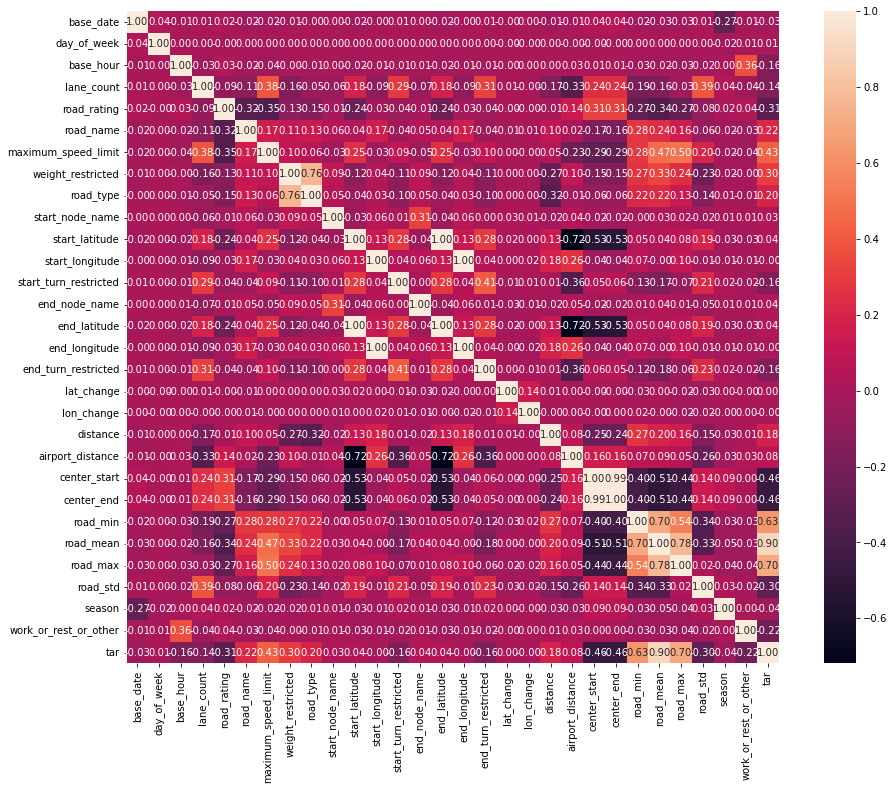

In [83]:
train_corr = X_train.corr()
f, ax = plt.subplots(figsize=(16, 12))
sns.heatmap(train_corr, annot=True, fmt = '.2f', square=True)

### 예측에 방해되는 컬럼 삭제

In [85]:
X_train.drop(['tar', 'road_code'], axis=1, inplace=True)

In [88]:
X_test.drop(['road_code'], axis=1, inplace=True)

# 3. Modeling

### LinearRegression
### DecisionTreeRegressor
### Ridge
### Kfold + RandomForestRegressor
### Kford + ExtraTreesRegressor
#### 대회 규칙인 MAE으로 오차 계산

### LinearRegression

In [41]:

from sklearn.model_selection import cross_val_score
from sklearn.linear_model import LinearRegression

lin_reg = LinearRegression()

scores = cross_val_score(lin_reg, X_train, y_train, scoring = 'neg_mean_squared_error', cv = 5)
lin_reg_rmse = np.sqrt((-scores).mean())
lin_reg_rmse


12.58878925952928

### DecisionTreeRegressor

In [42]:

from sklearn.tree import DecisionTreeRegressor

tree_reg = DecisionTreeRegressor()

tree_scores = cross_val_score(tree_reg, X_train, y_train, scoring="neg_mean_squared_error", cv=10, n_jobs=-1)

tree_rmse = np.sqrt(-tree_scores).mean()
tree_rmse



5.762942764000505

### Ridge

In [43]:
from sklearn.linear_model import Ridge, Lasso, ElasticNet

ridge = Ridge()
lasso = Lasso()
elastic = ElasticNet()
from sklearn.model_selection import GridSearchCV

In [44]:
# 평가지표 계산 함수
from sklearn.metrics import make_scorer
# log 값 변환 시 언더플로우 영향으로 log() 가 아닌 log1p() 를 이용하여 RMSLE 계산
def rmsle(y, pred, convertExp=True):
    if convertExp:
        y = np.expm1(y)
        pred = np.expm1(pred)
    
    log_y = np.log1p(y)
    log_pred = np.log1p(pred)
    squared_error = (log_y - log_pred) ** 2
    rmsle = np.sqrt(np.mean(squared_error))
    return rmsle

rmsle_scorer = make_scorer(rmsle, greater_is_better=False)

In [45]:
# 릿지모델
ridge = Ridge()
ridge_params = {'alpha' : [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400, 800, 900, 1000]} # 14개
gridsearch_ridge = GridSearchCV(ridge, ridge_params, scoring=rmsle_scorer, cv=5, n_jobs=-1) # 14 * 5

In [46]:
%time gridsearch_ridge.fit(X_train, y_train)

CPU times: total: 6.38 s
Wall time: 1min 20s


GridSearchCV(cv=5, estimator=Ridge(), n_jobs=-1,
             param_grid={'alpha': [0.1, 1, 2, 3, 4, 10, 30, 100, 200, 300, 400,
                                   800, 900, 1000]},
             scoring=make_scorer(rmsle, greater_is_better=False))

In [47]:
gridsearch_ridge.best_params_

{'alpha': 0.1}

In [48]:
cvres = gridsearch_ridge.cv_results_

for mean_score, params in zip(cvres['mean_test_score'], cvres['params']):
    print(-mean_score, params) # rmsle와 그 때의 하이퍼 파라미터

12.588786599362003 {'alpha': 0.1}
12.588786692168853 {'alpha': 1}
12.588787246469451 {'alpha': 2}
12.588788185941212 {'alpha': 3}
12.588789435047687 {'alpha': 4}
12.58880067305844 {'alpha': 10}
12.588843843630762 {'alpha': 30}
12.588922989673593 {'alpha': 100}
12.58896273188661 {'alpha': 200}
12.588980369917937 {'alpha': 300}
12.58899040688326 {'alpha': 400}
12.589008071609262 {'alpha': 800}
12.589010468154935 {'alpha': 900}
12.589012543748403 {'alpha': 1000}


### Kfold + RandomForestRegressor, ExtraTreesRegressor

In [90]:
from sklearn.model_selection import StratifiedKFold as kfold
from sklearn.ensemble import RandomForestRegressor,ExtraTreesRegressor
from sklearn.metrics import mean_absolute_error

# 연속적인 값인 만큼 stratify kfold 를 사용할 수 없지만 나누는 것은 kfold와 동일합니다.
kf = kfold(n_splits = 3, shuffle = True, random_state = 42)
split = kf.split(X_train, Y_train)

# 평균 mae를 확인하기 위한 리스트
mae_list1 = []
mae_list2 = []

# 폴드별 예측값 저장을 위한 리스트
test_pred_list1 = []
test_pred_list2 = []

for train, test in split:
    x_train, x_val, y_train, y_val = X_train.iloc[train], X_train.iloc[test], Y_train.iloc[train], Y_train.iloc[test]    

    rf = RandomForestRegressor(n_estimators=40, min_samples_leaf=10,
                                min_samples_split=10, random_state=2022)
    et = ExtraTreesRegressor(n_estimators = 40, min_samples_split=10, min_samples_leaf = 10, random_state = 2022)

    rf.fit(x_train, y_train)
    et.fit(x_train, y_train)

    pred1 = rf.predict(x_val)
    pred2 = et.predict(x_val)

    result1 = mean_absolute_error(pred1,y_val)
    result2 = mean_absolute_error(pred2,y_val)

    mae_list1.append(result1)
    mae_list2.append(result2)

    print(f'RandomForestRegressor mae : {result1:.4f}', end='\n\n')
    print(f'ExtraTreeRegressor mae : {result2:.4f}', end='\n\n')
    
    test_pred_list1.append(rf.predict(X_test))
    test_pred_list2.append(et.predict(X_test))

print(f'mean mae {np.mean(mae_list1):.4f}')
print(f'mean mae {np.mean(mae_list2):.4f}')

RandomForestRegressor mae : 2.9155

ExtraTreeRegressor mae : 2.9633

RandomForestRegressor mae : 2.9162

ExtraTreeRegressor mae : 2.9632

RandomForestRegressor mae : 2.9165

ExtraTreeRegressor mae : 2.9623

mean mae 2.9161
mean mae 2.9629


### 파일 저장

In [95]:
sample_submission = pd.read_csv('./Dataset/sample_submission.csv')

In [96]:
sample_submission

,id,target
0,TEST_000000,0
1,TEST_000001,0
2,TEST_000002,0
3,TEST_000003,0
4,TEST_000004,0
...,...,...
291236,TEST_291236,0
291237,TEST_291237,0
291238,TEST_291238,0
291239,TEST_291239,0


In [97]:
sample_submission['target'] = pred_last
sample_submission.to_csv("./All_Process.csv", index = False)

sample_submission

,id,target
0,TEST_000000,25.651475
1,TEST_000001,42.761723
2,TEST_000002,66.101029
3,TEST_000003,38.324813
4,TEST_000004,42.730050
...,...,...
291236,TEST_291236,47.148742
291237,TEST_291237,51.391279
291238,TEST_291238,23.297811
291239,TEST_291239,22.632192


### 제출 결과

- 751개팀 중 120위

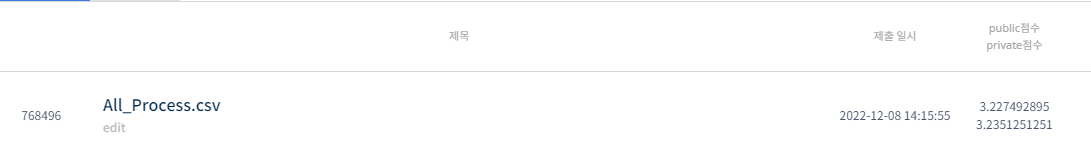